**Author:** Adnane SENNOUNE

This notebook presents my solution for the quarry sites classification. It includes the methodology, the results, and some remarks I made during some few hours of work.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms, models

# 1. Data Observation:




In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
X_train = pd.read_csv('/content/drive/My Drive/data/X_train.csv')
X_train.head(10)

,site_name,company_name,link,latitude,longitude,address,homepage,phone,sales_phone,email,sales_email,opening_hours,site_type,id,image_path
0,Carrières Daniel,NaN,https://www.google.com/maps/place/Carri%C3%A8r...,43.0477,-0.0473,"Le Village, 65100 Ger, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,949a5a8b-8e9d-40c5-8100-2f30a3e82f7b,data/images/train/949a5a8b-8e9d-40c5-8100-2f30...
1,Malet Horgues.,NaN,https://www.google.com/maps/place/Malet+Horgue...,43.1903,0.0916,"Chem. de Mansas, 65310 Horgues, France",NaN,NaN,NaN,NaN,NaN,NaN,Quarry,044d1092-4bb7-4e09-b073-113037a0a196,data/images/train/044d1092-4bb7-4e09-b073-1130...
2,Carrieres Plo,NaN,https://www.google.com/maps/place/Carrieres+Pl...,42.9605,0.3937,"Village, 65410 Ilhet, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,738e1bd8-6a64-40a9-85ff-c442965db618,data/images/train/738e1bd8-6a64-40a9-85ff-c442...
3,Dastugue Jean et Fils,NaN,https://www.google.com/maps/place/Dastugue+Jea...,43.0689,0.3865,"Rue du Bas Mour, 65250 La Barthe-de-Neste, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,1e07b5a8-b697-4971-bc39-b57d05084eea,data/images/train/1e07b5a8-b697-4971-bc39-b57d...
4,Pema Carrières Du Roc,NaN,https://www.google.com/maps/place/Pema+Carri%C...,43.6493,0.3439,"32320 Riguepeu, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,e96a46a3-9be3-4d3d-a3ec-2563c0e13ef2,data/images/train/e96a46a3-9be3-4d3d-a3ec-2563...
5,Ancienne carrière de Saint-Cricq,NaN,https://www.google.com/maps/place/Ancienne+car...,43.6676,0.6353,"Chem. de Saint-Cricq, 32000 Auch, France",NaN,NaN,NaN,NaN,NaN,NaN,Quarry,a912d14a-c2b2-48f8-be8c-670d21bfdd3c,data/images/train/a912d14a-c2b2-48f8-be8c-670d...
6,Carrière de marbre,NaN,https://www.google.com/maps/place/Carri%C3%A8r...,42.9815,1.0846,"Unnamed Road, 09200, Montégut-en-Couserans, Fr...",NaN,NaN,NaN,NaN,NaN,NaN,Quarry,7a789d84-10e0-45ba-9cb3-d57a22cebe39,data/images/train/7a789d84-10e0-45ba-9cb3-d57a...
7,Marbriere Grand Antique,NaN,https://www.google.com/maps/place/Marbriere+Gr...,42.9644,1.1052,"09200 Moulis, France",NaN,NaN,NaN,NaN,NaN,NaN,Quarry,4537c187-4b4e-415f-a723-a07934fd218b,data/images/train/4537c187-4b4e-415f-a723-a079...
8,Sablières de Garonne,NaN,https://www.google.com/maps/place/Sabli%C3%A8r...,43.3763,1.2916,"Village, 31410 Mauzac, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,ce2302ed-cee4-4a54-9c2e-2a20c67c556e,data/images/train/ce2302ed-cee4-4a54-9c2e-2a20...
9,Carrière Diogo,NaN,https://www.google.com/maps/place/Carri%C3%A8r...,44.5158,1.3315,"Les Vitarelles, 46150 Crayssac, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,5c0bed79-403c-454e-9a0f-8cd54f5db90e,data/images/train/5c0bed79-403c-454e-9a0f-8cd5...


In [6]:
len(X_train)

1039

We have 1039 images and their descriptions in the training dataset.

In [7]:
Y_train = pd.read_csv('/content/drive/My Drive/data/Y_train.csv')
Y_train.head(10)

,output
0,1
1,1
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


This is a barplot to check if the data is imbalanced or not. We remark that it's pretty well balanced, with slightly more non-quarry sites than quarry ones in this dataset.

Text(0, 0.5, 'Count')

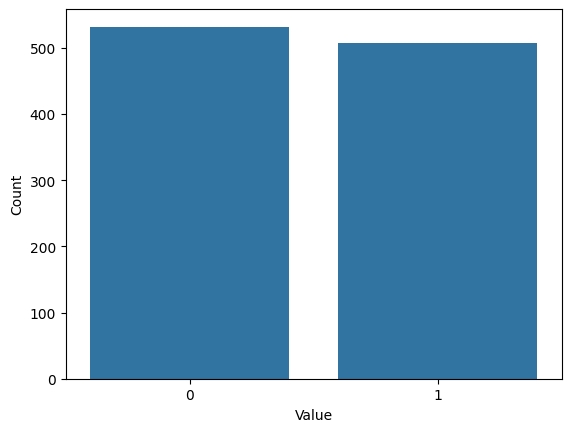

In [8]:
value_counts = Y_train['output'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Value')
plt.ylabel('Count')

Since the CSV "X_train" has no column headers, we will name the columns in the dataframe "X_train" in order to facilitate the indexing later:

In [9]:
columns= ['site_name','company_name','link','latitude','longitude','address','homepage','phone','sales_phone','email','sales_email','opening_hours','site_type','id','image_path']

X_train= pd.DataFrame(X_train, columns=columns)
X_train.head()

,site_name,company_name,link,latitude,longitude,address,homepage,phone,sales_phone,email,sales_email,opening_hours,site_type,id,image_path
0,Carrières Daniel,NaN,https://www.google.com/maps/place/Carri%C3%A8r...,43.0477,-0.0473,"Le Village, 65100 Ger, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,949a5a8b-8e9d-40c5-8100-2f30a3e82f7b,data/images/train/949a5a8b-8e9d-40c5-8100-2f30...
1,Malet Horgues.,NaN,https://www.google.com/maps/place/Malet+Horgue...,43.1903,0.0916,"Chem. de Mansas, 65310 Horgues, France",NaN,NaN,NaN,NaN,NaN,NaN,Quarry,044d1092-4bb7-4e09-b073-113037a0a196,data/images/train/044d1092-4bb7-4e09-b073-1130...
2,Carrieres Plo,NaN,https://www.google.com/maps/place/Carrieres+Pl...,42.9605,0.3937,"Village, 65410 Ilhet, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,738e1bd8-6a64-40a9-85ff-c442965db618,data/images/train/738e1bd8-6a64-40a9-85ff-c442...
3,Dastugue Jean et Fils,NaN,https://www.google.com/maps/place/Dastugue+Jea...,43.0689,0.3865,"Rue du Bas Mour, 65250 La Barthe-de-Neste, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,1e07b5a8-b697-4971-bc39-b57d05084eea,data/images/train/1e07b5a8-b697-4971-bc39-b57d...
4,Pema Carrières Du Roc,NaN,https://www.google.com/maps/place/Pema+Carri%C...,43.6493,0.3439,"32320 Riguepeu, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,e96a46a3-9be3-4d3d-a3ec-2563c0e13ef2,data/images/train/e96a46a3-9be3-4d3d-a3ec-2563...


We observe that "site_type" has text values to indicate the type, while the column "output" has binary values. Let's add another column that contains binary values in order to compare the given indication with the actual site type:

In [10]:
X_train['site_type_binary'] = X_train['site_type'].apply(lambda x: 1 if str(x) == "Quarry" else 0)
X_train.head()

,site_name,company_name,link,latitude,longitude,address,homepage,phone,sales_phone,email,sales_email,opening_hours,site_type,id,image_path,site_type_binary
0,Carrières Daniel,NaN,https://www.google.com/maps/place/Carri%C3%A8r...,43.0477,-0.0473,"Le Village, 65100 Ger, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,949a5a8b-8e9d-40c5-8100-2f30a3e82f7b,data/images/train/949a5a8b-8e9d-40c5-8100-2f30...,1
1,Malet Horgues.,NaN,https://www.google.com/maps/place/Malet+Horgue...,43.1903,0.0916,"Chem. de Mansas, 65310 Horgues, France",NaN,NaN,NaN,NaN,NaN,NaN,Quarry,044d1092-4bb7-4e09-b073-113037a0a196,data/images/train/044d1092-4bb7-4e09-b073-1130...,1
2,Carrieres Plo,NaN,https://www.google.com/maps/place/Carrieres+Pl...,42.9605,0.3937,"Village, 65410 Ilhet, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,738e1bd8-6a64-40a9-85ff-c442965db618,data/images/train/738e1bd8-6a64-40a9-85ff-c442...,1
3,Dastugue Jean et Fils,NaN,https://www.google.com/maps/place/Dastugue+Jea...,43.0689,0.3865,"Rue du Bas Mour, 65250 La Barthe-de-Neste, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,1e07b5a8-b697-4971-bc39-b57d05084eea,data/images/train/1e07b5a8-b697-4971-bc39-b57d...,1
4,Pema Carrières Du Roc,NaN,https://www.google.com/maps/place/Pema+Carri%C...,43.6493,0.3439,"32320 Riguepeu, France",NaN,#ERROR!,NaN,NaN,NaN,NaN,Quarry,e96a46a3-9be3-4d3d-a3ec-2563c0e13ef2,data/images/train/e96a46a3-9be3-4d3d-a3ec-2563...,1


In [11]:
diff = (X_train['site_type_binary'] != Y_train['output']).sum()

print(diff)

538


We conclude that the column "Site_type" gives incorrect indications in 51.78% of the cases!

This is just a test of how to retrieve images based on the "image_path" column:

In [12]:
main_path = '/content/drive/My Drive/'

def load_image(image_path):
    full_path = os.path.join(main_path, image_path)
    img = Image.open(full_path)
    return img

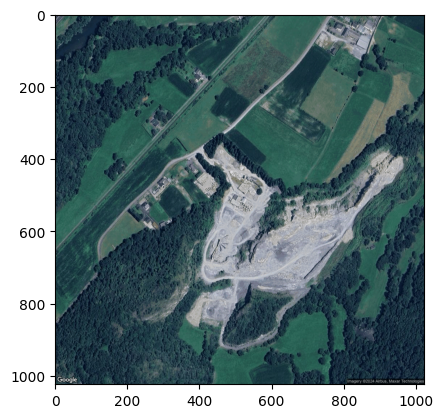

In [13]:
image_path= X_train.loc[0,'image_path']
image= load_image(image_path)
plt.imshow(image)

Other interesting columns to inspect are "latitude" and "longitude". This scatter plot shows all the positions of the sites:

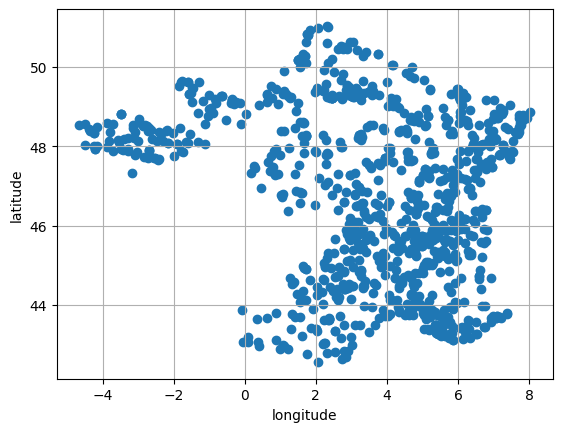

In [14]:
plt.scatter(X_train['longitude'], X_train['latitude'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True)

We can observe that the points form the shape of hexagonal France, with sites spread all over the country except the southwest in the "Nouvelle Aquitaine" region.

# 2 - Training the model: Pretrained Resnet-18

The first reflex in the choice of the model is to fine-tune a pretrained model, one of those models, one that I had previously the opportunity to work with is "Resnet-18", by using this model, we can benefit from the features learned during training on a large dataset, which helps capture rich visual representations relevant to our task. So we will freeze most of the parameters of the model except the ones of the last fully connected layer that will be fine-tuned. This approach allows us to capitalize on the generalization power of the pretrained model while tailoring the classifier to our quarry site identification task, potentially leading to improved performance.

This code is well commented in order to explain every step for the training of the model:

In [16]:
main_path = '/content/drive/My Drive/'

#Transformations to be applied on images: Resizing, converting them to tensors, normalization to values between 0 & 1
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
])

#Merging X_train and Y_train in a single DF "train_data"
train_data = pd.merge(X_train, Y_train, left_index=True, right_index=True)

#Defining the class "PrepareData" that customize Dataset class in order to load images and labels
class PrepareData(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'image_path']
        img_label = self.dataframe.loc[idx, 'output']

        image = Image.open(os.path.join(main_path, img_name))

        if self.transform:
            image = self.transform(image)

        return image, img_label

#Creating the object dataset using the previous class and the transformations
dataset = PrepareData(train_data, transform=transform)

#Splitting the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

#Defining train and validation Data loaders
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

#Setting the device on either the GPU (if available) or the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Loading the pre-trained Resnet-18 and freezeing the parameters
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

#Modifying the last fully connected layer for the binary classification task
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model = model.to(device)

#Hyperparameters:
num_epochs = 10
learning_rate = 0.001

#Defining the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

#Training loop
model.train()
for epoch in range(num_epochs):
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)

    #Validation
    model.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            predictions = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += len(labels)

        epoch_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(epoch_val_loss)
        val_accuracy = correct_predictions / total_predictions
        val_accuracy_history.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


Epoch [1/10], Train Loss: 0.6248, Val Loss: 0.8002, Val Accuracy: 0.5000
Epoch [2/10], Train Loss: 0.7016, Val Loss: 0.6936, Val Accuracy: 0.5000
Epoch [3/10], Train Loss: 0.6989, Val Loss: 0.6996, Val Accuracy: 0.5000
Epoch [4/10], Train Loss: 0.7002, Val Loss: 0.6967, Val Accuracy: 0.5000
Epoch [5/10], Train Loss: 0.6994, Val Loss: 0.7003, Val Accuracy: 0.5000
Epoch [6/10], Train Loss: 0.6991, Val Loss: 0.7011, Val Accuracy: 0.5000
Epoch [7/10], Train Loss: 0.6970, Val Loss: 0.6932, Val Accuracy: 0.5000
Epoch [8/10], Train Loss: 0.6982, Val Loss: 0.6933, Val Accuracy: 0.5000
Epoch [9/10], Train Loss: 0.6940, Val Loss: 0.6949, Val Accuracy: 0.5000
Epoch [10/10], Train Loss: 0.6942, Val Loss: 0.6931, Val Accuracy: 0.5000


In [43]:
print(device)

cpu


The previous code takes approximately 15 minutes, but I'm only using the CPU. Running it on the GPU would be much faster.

Talking about results, the train and validation losses seem to not improve effectively and the validation accuracy remains constant at 50%, all of that suggests that the model is not learning well, we can visualize this in the loss history plot:

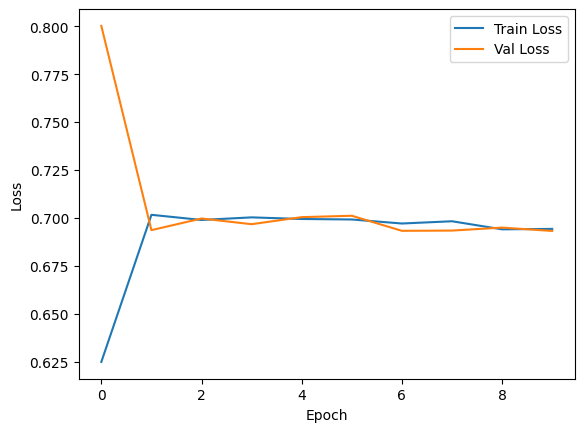

In [17]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Since I started with a classic value for the learning rate (0.001) that might be low for this case, an interesting approach is to start with a higher learning rate and add a scheduler for it, this last one will facilitate a stable and efficient training (most of the code remains the same and the additional lines are commented):

In [21]:
main_path = '/content/drive/My Drive/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)])

train_data = pd.merge(X_train, Y_train, left_index=True, right_index=True)

class PrepareData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'image_path']
        img_label = self.dataframe.loc[idx, 'output']

        image = Image.open(os.path.join(main_path, img_name))

        if self.transform:
            image = self.transform(image)

        return image, img_label

dataset = PrepareData(train_data, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model = model.to(device)

num_epochs = 10
learning_rate = 0.01

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Adding a learning rate scheduler:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)

    model.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            predictions = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(epoch_val_loss)
        val_accuracy = correct_predictions / total_predictions
        val_accuracy_history.append(val_accuracy)

        # Step the scheduler based on the validation loss
        scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/10], Train Loss: 0.8070, Val Loss: 0.8591, Val Accuracy: 0.5240
Epoch [2/10], Train Loss: 0.6329, Val Loss: 0.6464, Val Accuracy: 0.6250
Epoch [3/10], Train Loss: 0.5392, Val Loss: 0.7697, Val Accuracy: 0.6538
Epoch [4/10], Train Loss: 0.4578, Val Loss: 0.6443, Val Accuracy: 0.7260
Epoch [5/10], Train Loss: 0.4607, Val Loss: 0.6930, Val Accuracy: 0.7260
Epoch [6/10], Train Loss: 0.4697, Val Loss: 0.7548, Val Accuracy: 0.7019
Epoch [7/10], Train Loss: 0.4976, Val Loss: 0.7503, Val Accuracy: 0.7212
Epoch [8/10], Train Loss: 0.3813, Val Loss: 0.7372, Val Accuracy: 0.7163
Epoch [9/10], Train Loss: 0.3671, Val Loss: 0.7408, Val Accuracy: 0.7115
Epoch [10/10], Train Loss: 0.3751, Val Loss: 0.7429, Val Accuracy: 0.7115


In [26]:
acc_resnet = val_accuracy_history[-1]*100
print(f'Validation accuracy of the model: {acc_resnet:.4f}%')

Validation accuracy of the model: 71.1538%


We observe an improvement in the model's performance, with the validation accuracy increasing from 50% to 71%. However, we also notice a significant disparity between the training loss and validation loss, indicating a potential overfitting issue.

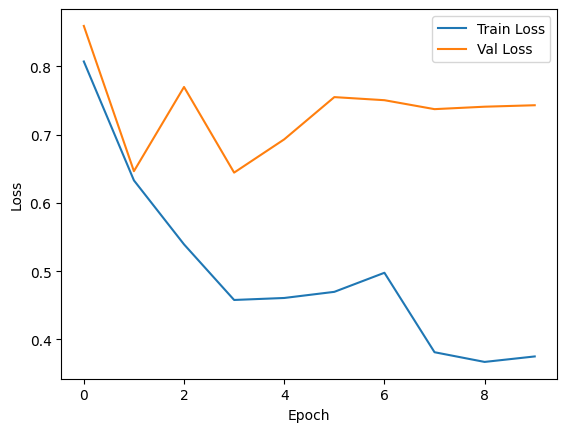

In [22]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [25]:
model_path = '/content/drive/My Drive/data/quarry_models/'
torch.save(model.state_dict(), os.path.join(model_path, 'resnet18_quarry.pth'))

Let's try to adress that overfitting problem. for that, instead of fine-tuning just the last layer, we fine-tune the last two layers and add a Dropout regularization with a probability of 0.5, and we increase the number of epochs:

In [27]:
main_path = '/content/drive/My Drive/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)])

train_data = pd.merge(X_train, Y_train, left_index=True, right_index=True)

class PrepareData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'image_path']
        img_label = self.dataframe.loc[idx, 'output']

        image = Image.open(os.path.join(main_path, img_name))

        if self.transform:
            image = self.transform(image)

        return image, img_label

dataset = PrepareData(train_data, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5), #regularization
    nn.Linear(512, 1))
model = model.to(device)

num_epochs = 20 #more epochs
learning_rate = 0.01

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)  #modification of the scheduler

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)

    model.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            predictions = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(epoch_val_loss)
        val_accuracy = correct_predictions / total_predictions
        val_accuracy_history.append(val_accuracy)

        scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/20], Train Loss: 1.2767, Val Loss: 0.6980, Val Accuracy: 0.4904
Epoch [2/20], Train Loss: 0.5468, Val Loss: 1.0322, Val Accuracy: 0.4952
Epoch [3/20], Train Loss: 0.5972, Val Loss: 0.5434, Val Accuracy: 0.7788
Epoch [4/20], Train Loss: 0.5987, Val Loss: 0.5815, Val Accuracy: 0.6683
Epoch [5/20], Train Loss: 0.5984, Val Loss: 0.5436, Val Accuracy: 0.7692
Epoch [6/20], Train Loss: 0.5576, Val Loss: 0.5332, Val Accuracy: 0.7356
Epoch [7/20], Train Loss: 0.5742, Val Loss: 0.5266, Val Accuracy: 0.7548
Epoch [8/20], Train Loss: 0.5697, Val Loss: 0.5340, Val Accuracy: 0.7644
Epoch [9/20], Train Loss: 0.5569, Val Loss: 0.5175, Val Accuracy: 0.7644
Epoch [10/20], Train Loss: 0.5238, Val Loss: 0.5454, Val Accuracy: 0.7163
Epoch [11/20], Train Loss: 0.5173, Val Loss: 0.6099, Val Accuracy: 0.6587
Epoch [12/20], Train Loss: 0.5168, Val Loss: 0.5350, Val Accuracy: 0.7596
Epoch [13/20], Train Loss: 0.5201, Val Loss: 0.5698, Val Accuracy: 0.7548
Epoch [14/20], Train Loss: 0.5436, Val Loss: 0.

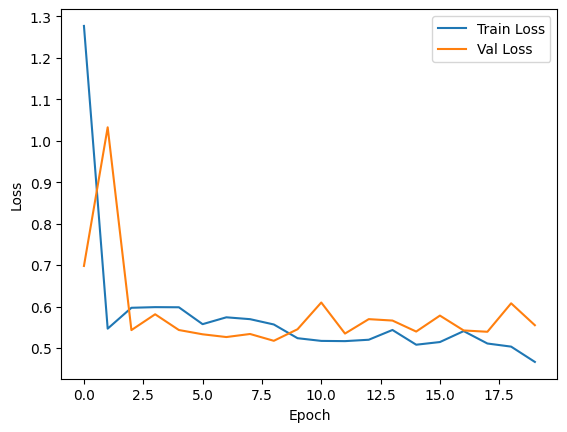

In [28]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [30]:
acc_resnet_bis = val_accuracy_history[-1]*100
print(f'Validation accuracy of the model: {acc_resnet_bis:.4f}%')

Validation accuracy of the model: 75.9615%


After applying dropout regularization, the model's performance has shown some improvement, with a final validation accuracy of 76%. Also there is convergence of both training and validation losses to comparable values which indicates that the model is no longer significantly overfitting to the training data. However, there are some fluctuations in the validation loss and accuracy across epochs, suggesting that the model's performance may not be entirely stable, so further fine-tuning or exploring different regularization techniques might be necessary to achieve more consistent and satisfactory results.

In [31]:
torch.save(model.state_dict(), os.path.join(model_path, 'resnet18_quarry_bis.pth'))

# 3. Applying the model on test data:

In [32]:
X_test = pd.read_csv('/content/drive/My Drive/data/X_test.csv')
X_test.head()

,site_name,company_name,link,latitude,longitude,address,homepage,phone,sales_phone,email,sales_email,opening_hours,site_type,id,image_path
0,"New Enterprise Stone &amp; Lime Co., Inc. -- A...",Unknown,https://www.google.com/maps/place/New+Enterpri...,40.0046,-78.4190,"526 Ashcom Rd, Everett, PA 15537, United States",nesl.com,+1 800-426-7334,NaN,NaN,NaN,NaN,Quarry,2c454368-0cff-4195-8290-4cfaab9082ec,data/images/test/2c454368-0cff-4195-8290-4cfaa...
1,"New Enterprise Stone &amp; Lime Co., Inc. -- R...",Unknown,https://www.google.com/maps/place/New+Enterpri...,40.3455,-78.4039,"8078 Woodbury Pike, Roaring Spring, PA 16673, ...",nesl.com,+1 800-426-7334,NaN,NaN,NaN,NaN,Quarry,8ac10caa-24a9-475e-9dc7-4532cb818bff,data/images/test/8ac10caa-24a9-475e-9dc7-4532c...
2,"New Enterprise Stone &amp; Lime Co., Inc. -- T...",Unknown,https://www.google.com/maps/place/New+Enterpri...,40.6653,-78.2130,"853 Birmingham Pike, Tyrone, PA 16686, United ...",nesl.com,+1 800-426-7334,NaN,NaN,NaN,NaN,Aggregate supplier,dc097ae3-d1a9-4c88-aec6-82858d70a8eb,data/images/test/dc097ae3-d1a9-4c88-aec6-82858...
3,"New Enterprise Stone &amp; Lime Co., Inc. -- U...",Unknown,https://www.google.com/maps/place/New+Enterpri...,40.6205,-78.1673,"3279 Johnson Hill, Tyrone, PA 16686, United St...",nesl.com,+1 800-426-7334,NaN,NaN,NaN,NaN,Quarry,aff045a5-d1d1-4713-8a99-99371965bc78,data/images/test/aff045a5-d1d1-4713-8a99-99371...
4,Penn State Stone Valley,Unknown,https://www.google.com/maps/place/Penn+State+S...,40.4848,-78.0103,"RR 2, Huntingdon, PA 16652, United States",studentaffairs.psu.edu,+1 814-667-3458,NaN,NaN,NaN,NaN,Stone supplier,b5240514-6833-49e4-902a-887495ea6952,data/images/test/b5240514-6833-49e4-902a-88749...


In [38]:
len(X_test)

525

In [33]:
Sub_ex = pd.read_csv('/content/drive/My Drive/data/Submission_example.csv')
Sub_ex.head()

,output
0,0
1,1
2,0
3,1
4,0


In [36]:
Y_pred = pd.DataFrame()

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1))
#Loading the saved model
model.load_state_dict(torch.load(os.path.join(model_path, 'resnet18_quarry_bis.pth')))

#Setting the model to evaluation
model.eval()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
])

for index, row in X_test.iterrows():
    image_path = row['image_path']
    image = Image.open(os.path.join(main_path, image_path))
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
    pred = torch.round(torch.sigmoid(output)).item()
    Y_pred.loc[index, 'output'] = pred

print(Y_pred)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


     output
0       1.0
1       0.0
2       1.0
3       1.0
4       0.0
..      ...
520     1.0
521     0.0
522     0.0
523     0.0
524     0.0

[525 rows x 1 columns]


Saving predictions:

In [37]:
Y_pred.to_csv('/content/drive/My Drive/data/Y_pred.csv', index=False)

# 4. Quantization:

Since one of the contraints is cost, an interesting approach is quatization which is the process of reducing the precision of numerical data, often used in machine learning models to enhance efficiency in terms of memory and computation:

In [39]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    print("model: ", label, " \t", "Size (KB):", size / 1e3)
    os.remove("temp.p")
    return size


print_size_of_model(model, "fp32")

model:  fp32  	 Size (KB): 45829.562


45829562

In [40]:
import torch.quantization


quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)
print_size_of_model(quantized_model, "int8")

model:  int8  	 Size (KB): 45043.11


45043110

We observe that quantization reduced the size of the model by approximately 0.8 MB, which, while not a big difference, is still noteworthy. The minimal reduction is attributed to the model being pretrained with many frozen parameters. If the model were trained from scratch, the impact of quantization would likely be more significant. In our scenario, exploring training-aware quantization could be more suitable: https://pytorch.org/docs/stable/quantization.html#torch.quantization.quantize_dynamic

# 5. Further reflexion:

Since it's always interesting to test with less complex models, here is a quick application of customized CNN model on the data:

In [55]:
class CNNbasic(nn.Module):
    def __init__(self):
        super(CNNbasic, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [56]:
class PrepareData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'image_path']
        img_label = self.dataframe.loc[idx, 'output']
        image = Image.open(os.path.join(main_path, img_name))
        if self.transform:
            image = self.transform(image)
        return image, img_label

In [57]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
])

train_data = pd.merge(X_train, Y_train, left_index=True, right_index=True)
dataset = PrepareData(train_data, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization
model2 = CNNbasic().to(device)

num_epochs=10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training loop
for epoch in range(num_epochs):
    model2.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)

    #validation
    model2.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
        epoch_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_predictions / total_predictions
        scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/10], Train Loss: 1.0380, Val Loss: 0.6955, Val Accuracy: 0.4567
Epoch [2/10], Train Loss: 0.6938, Val Loss: 0.6929, Val Accuracy: 0.5433
Epoch [3/10], Train Loss: 0.6933, Val Loss: 0.6929, Val Accuracy: 0.5433
Epoch [4/10], Train Loss: 0.6934, Val Loss: 0.6931, Val Accuracy: 0.5433
Epoch [5/10], Train Loss: 0.6936, Val Loss: 0.6924, Val Accuracy: 0.5433
Epoch [6/10], Train Loss: 0.6937, Val Loss: 0.6915, Val Accuracy: 0.5433
Epoch [7/10], Train Loss: 0.6932, Val Loss: 0.6932, Val Accuracy: 0.4567
Epoch [8/10], Train Loss: 0.6935, Val Loss: 0.6933, Val Accuracy: 0.4567
Epoch [9/10], Train Loss: 0.6938, Val Loss: 0.6924, Val Accuracy: 0.5433
Epoch [10/10], Train Loss: 0.6933, Val Loss: 0.6931, Val Accuracy: 0.5433


The results show that the model is not learning effectively, as the training, the validation losses and the validation accuracy are not improving over epochs. So this might be indicative of an underfitting: the model might be too simple for the task.

As part of further reflection, here are the points I would address if I had more time:

*   More Hyperparameter tuning on the final saved resnet-18 model in order to improve its performance further mode.
*   Benchmark of various pretrained models: Resnet-50, AlexNet, DenseNet21, VGG16 ...
*   Adding the training-aware quantization in order to optimize the memory and computation (and thus the cost).
*   Implementing more sophisticated solutions: incorporating object detection techniques such as YOLO, specifically YOLOv3 or YOLOv4, to identify relevant features characterizing a quarry site in images. By tagging images with YOLO, we can extract valuable contextual information before passing them to the pretrained classification model.

